In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import bisect
from labellines import labelLines

In [2]:
class vdB():
    def __init__(self):
        self.vr     = sp.symbols('v_r')
        self.Pr     = sp.symbols('P_r')
        self.Tr     = sp.symbols('T_r')
        Pr          = self.Pr
        vr          = self.vr
        Tr          = self.Tr
        self.Pr_exp = 8*Tr/(3*vr-1)-3/vr**2
        self.Tr_exp = (Pr + 3/vr**2)*(3*vr-1)/8
        self.dPdv   = sp.diff(self.Pr_exp,vr)
        self.d2Pdv2 = sp.diff(self.dPdv,vr)
        self.Pr_int = sp.integrate(self.Pr_exp,vr)
    def vr_subs(self,v_arr,exp):
        y   = [] 
        for v in v_arr:
            y.append(exp.subs(self.vr,v))
        return y
    def isobar(self,P,v_arr):
        exp = self.Tr_exp.subs(self.Pr,P)
        return self.vr_subs(v_arr,exp)
    def isotherm(self,T,v_arr):
        exp = self.Pr_exp.subs(self.Tr,T)
        return self.vr_subs(v_arr,exp)
    def isotherm_comp(self,T,v_arr):
        exp = self.dPdv.subs(self.Tr,T)
        return self.vr_subs(v_arr,exp)
    def isotherm_curv(self,T,v_arr):
        exp = self.d2Pdv2.subs(self.Tr,T)
        return self.vr_subs(v_arr,exp)
    def root(self,T,P,x0):
        exp = P - self.Pr_exp.subs(self.Tr,T)
        return fsolve(self.vr_subs,x0=x0,args=exp)[0]
    def minmax(self,T):
        if T > 1:
            return None
        x    = np.linspace(0.4,1,100)
        y    = self.isotherm_comp(T,x)
        min_ = np.interp(0,y,x)
        x    = np.linspace(10,1,100)
        y    = self.isotherm_comp(T,x)
        max_ = np.interp(0,y,x)
        return min_,max_
    def sat_Pr(self,T):
        def area_error(P):
            v1 = self.root(T,P,0.4)
            v2 = self.root(T,P,1.0)
            v3 = self.root(T,P,3.0)
            #print(v1,v2,v3)
            if v1 == v2 or v2 == v3 or v3 == v1:
                print("Failing")
                return None
            exp   = self.Pr_int.subs(self.Tr,T)
            area  = self.vr_subs([v3],exp)[0] - self.vr_subs([v1],exp)[0] - P*(v3-v1)
            return area
        vr_min,vr_max = self.minmax(T)
        Pr_min,Pr_max = self.isotherm(T,[vr_min])[0],self.isotherm(T,[vr_max])[0]
        return bisect(area_error, Pr_min,Pr_max)

In [3]:
obj = vdB()

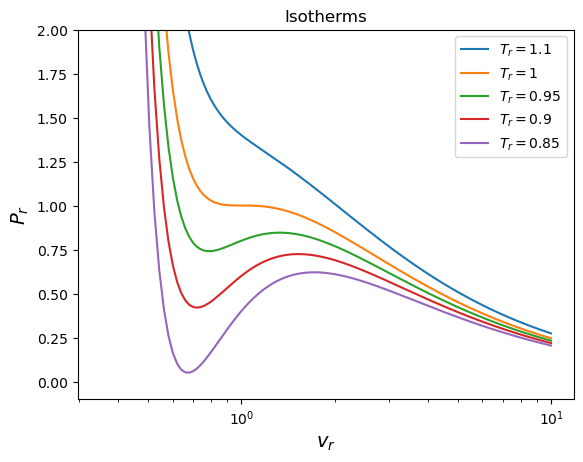

In [4]:
x  = np.linspace(0.35, 10, 500)
for Tr in [1.1,1,0.95,0.9,0.85]:
    y  = obj.isotherm(Tr,x)
    plt.plot(x,y,label='$T_r = $'+str(np.round(Tr,2)))
plt.ylabel('$P_r$',fontsize=14)
plt.xlabel('$v_r$',fontsize=14)
plt.ylim(-0.1,2)
plt.title("Isotherms")
plt.xscale('log')
plt.legend()

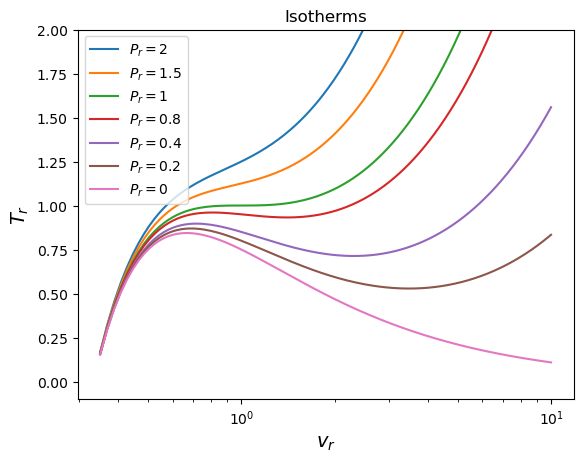

In [25]:
x  = np.linspace(0.35, 10, 500)
for Pr in [2,1.5,1,0.8,0.4,0.2,0]:
    y  = obj.isobar(Pr,x)
    plt.plot(x,y,label='$P_r = $'+str(np.round(Pr,2)))
plt.ylabel('$T_r$',fontsize=14)
plt.xlabel('$v_r$',fontsize=14)
plt.ylim(-0.1,2)
plt.title("Isotherms")
plt.xscale('log')
plt.legend()

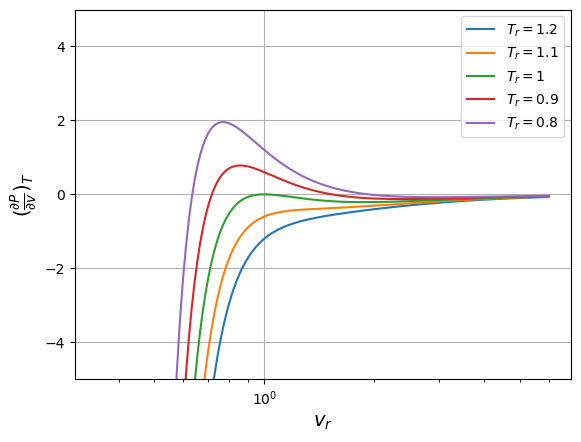

In [6]:
x  = np.linspace(0.35, 6, 500)
for Tr in [1.2,1.1,1,0.9,0.8]:
    y  = obj.isotherm_comp(Tr,x)
    plt.plot(x,y,label='$T_r = $'+str(np.round(Tr,2)))
plt.ylabel(r"$(\frac{\partial P}{\partial v})_T$",fontsize=14)
plt.xlabel('$v_r$',fontsize=14)
plt.xscale('log')
plt.ylim(-5,5)
plt.legend()
plt.grid(1)

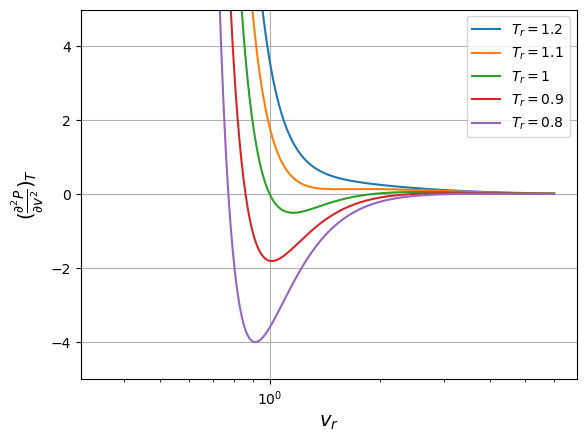

In [7]:
x  = np.linspace(0.35, 6, 500)
for Tr in [1.2,1.1,1,0.9,0.8]:
    y  = obj.isotherm_curv(Tr,x)
    plt.plot(x,y,label='$T_r = $'+str(np.round(Tr,2)))
plt.ylabel(r"$(\frac{\partial P}{\partial v})_T$",fontsize=14)
plt.ylabel(r"$(\frac{\partial^2 P}{\partial v^2})_T$",fontsize=14)
plt.xlabel('$v_r$',fontsize=14)
plt.xscale('log')
plt.ylim(-5,5)
plt.legend()
plt.grid(1)

In [21]:
def function(Tr,a=0.6,b=3):
    Pr   = obj.sat_Pr(Tr)
    v1   = obj.root(Tr,Pr,0.4)
    v2   = obj.root(Tr,Pr,1.0)
    v3   = obj.root(Tr,Pr,3.0) 
    vr_min,vr_max = obj.minmax(Tr)
    Pr_min,Pr_max = obj.isotherm(Tr,[vr_min])[0],obj.isotherm(Tr,[vr_max])[0]
    
    plt.plot([a,b],[Pr]*2,color="gray")
    
    x = np.linspace(a, v1, 100)
    y  = obj.isotherm(Tr,x)
    plt.plot(x,y,color="0")
    
    x = np.linspace(v1, vr_min, 100)
    y  = obj.isotherm(Tr,x)
    plt.plot(x,y,color="0",linestyle="dashed")
    
    x = np.linspace(vr_min, vr_max, 100)
    y  = obj.isotherm(Tr,x)
    plt.plot(x,y,color="0",linestyle="dotted")
    
    x = np.linspace(vr_max, v3, 100)
    y  = obj.isotherm(Tr,x)
    plt.plot(x,y,color="0",linestyle="dashed")
    
    x = np.linspace(v3, b, 100)
    y  = obj.isotherm(Tr,x)
    plt.plot(x,y,color="0")

    for x in [v1,v2,v3]:
        plt.scatter(x,Pr,color="0")
    plt.scatter(vr_min,Pr_min,color="0")
    plt.scatter(vr_max,Pr_max,color="0")
    
    x  = np.linspace(v1, v2, 10)
    y1 = (np.ones(10)*Pr).tolist()
    y  = obj.isotherm(Tr,x)
    
    x = np.linspace(v2, v3, 10)
    y = obj.isotherm(Tr,x)

    plt.ylabel('$P_r$',fontsize=14)
    plt.xlabel('$v_r$',fontsize=14)
    plt.text(v1*1.02    ,Pr*1.02    ,'A',fontsize=14)
    plt.text(v3*1.02    ,Pr*1.02    ,'E',fontsize=14)
    plt.text(v2*0.96    ,Pr*1.02    ,'C',fontsize=14)
    plt.text(vr_max*1.01,Pr_max*1.02,'D',fontsize=14)
    plt.text(vr_min*1.02,Pr_min*0.96,'B',fontsize=14)
    plt.grid(1)
    return Pr

0.81187924336487

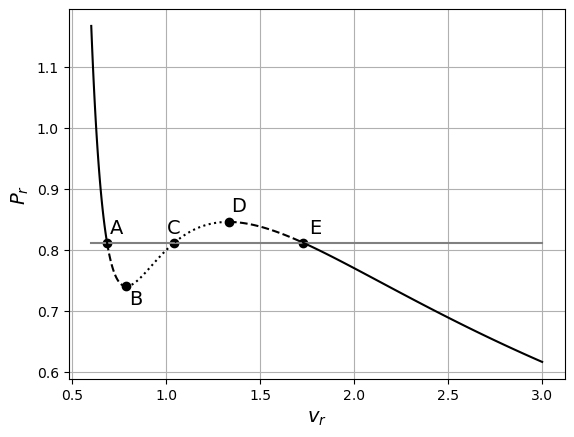

In [22]:
function(0.95)

0.6469983518722081

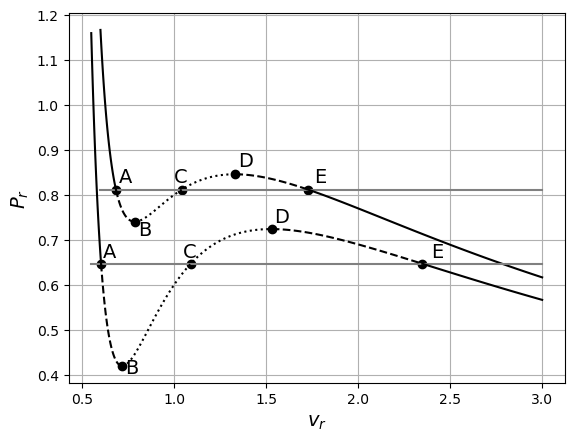

In [24]:
function(0.95)
function(0.9,a=0.55)